In [1]:
%matplotlib inline

============================
WV Satellite Overlay Example
============================

Plot a Gini Satellite file and overlay GFS-based data.

Using the Gini read capability of MetPy with Siphon to bring in the best GFS
data according to the current time, plot an overlay of WV imagery with 300-hPa
Geopotential Heights and Wind Barbs.

Begin with imports, need a lot for this task.

In [2]:
# A whole bunch of imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
from metpy.io import GiniFile
from metpy.plots.ctables import registry
from metpy.units import units
from netCDF4 import num2date
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
import xarray as xr


Get satellite data and set projection based on that data.

In [3]:
# Scan the catalog and download the data
satcat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/satellite/'
                    'WV/WEST-CONUS_4km/current/catalog.xml')
dataset = satcat.datasets[0]
f = GiniFile(dataset.remote_open())
gini_ds = xr.open_dataset(f)

# Pull parts out of the data file
dat = gini_ds.metpy.parse_cf('WV')
data_var = gini_ds.variables['WV']
x = gini_ds.variables['x'][:]
y = gini_ds.variables['y'][:]
timestamp = f.prod_desc.datetime

Use Siphon to obtain data that is close to the time of the satellite file

In [4]:
gfscat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                    'NCEP/GFS/Global_0p5deg/catalog.xml')
dataset = gfscat.datasets['Best GFS Half Degree Forecast Time Series']
ncss = dataset.subset()

# First get wind components data
query_wind = ncss.query()
query_wind.variables('u-component_of_wind_isobaric',
                     'v-component_of_wind_isobaric')
query_wind.add_lonlat().vertical_level(300 * 100)
query_wind.time(timestamp)  # Use the time from the GINI file
query_wind.lonlat_box(north=65, south=15, east=310, west=220)
data_wind = ncss.get_data(query_wind)

# Second get Geopotential height data because it has a different number of levels
query_hght = ncss.query()
query_hght.variables('Geopotential_height_isobaric')
query_hght.add_lonlat().vertical_level(300 * 100)
query_hght.time(timestamp)  # Use the time from the GINI file
query_hght.lonlat_box(north=65, south=15, east=310, west=220)
data_hght = ncss.get_data(query_hght)

Pull out specific variables and attach units.

In [5]:
hght_300 = data_hght.variables['Geopotential_height_isobaric'][:].squeeze()
uwnd_300 = data_wind.variables['u-component_of_wind_isobaric'][:].squeeze()
vwnd_300 = data_wind.variables['v-component_of_wind_isobaric'][:].squeeze()

Z_300 = units.meter * ndimage.gaussian_filter(hght_300, sigma=4, order=0)
U_300 = units('m/s') * ndimage.gaussian_filter(uwnd_300, sigma=4, order=0)
V_300 = units('m/s') * ndimage.gaussian_filter(vwnd_300, sigma=4, order=0)

lon = data_hght.variables['lon'][:]
lat = data_hght.variables['lat'][:]
time = data_hght.variables[data_hght.variables['Geopotential_height_isobaric'].dimensions[0]]
vtime = num2date(time[:], time.units)

Create figure with an overlay of WV Imagery with 300-hPa Heights and Wind

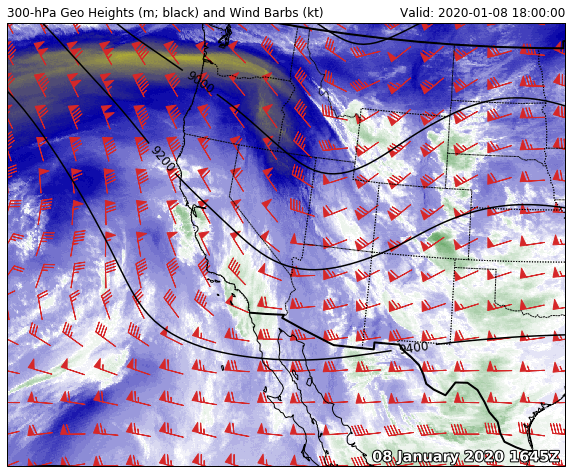

In [6]:
# Create the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=dat.metpy.cartopy_crs)

# Add mapping information
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Plot the image with our colormapping choices
wv_norm, wv_cmap = registry.get_with_range('WVCIMSS', 100, 260)
im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap=wv_cmap, norm=wv_norm)

# Add the text, complete with outline
text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')
text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='black')])

# PLOT 300-hPa Geopotential Heights and Wind Barbs
ax.set_extent([-132, -95, 25, 47], ccrs.Geodetic())
cs = ax.contour(lon, lat, Z_300, colors='black', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
          fmt='%i', rightside_up=True, use_clabeltext=True)

ax.barbs(lon, lat, U_300.to('knots').m, V_300.to('knots').m, color='tab:red',
         length=7, regrid_shape=15, pivot='middle', transform=ccrs.PlateCarree())

ax.set_title('300-hPa Geo Heights (m; black) and Wind Barbs (kt)', loc='left')
ax.set_title('Valid: {}'.format(vtime[0]), loc='right')

plt.show()